get data from local database 

successfully connected to database
90065
('# of parcels updated in 2020: ', 108)
('# of parcels updated in 2021: ', 27)
('total # of parcels in table: ', 29700)


,ain,taxratearea,usecode,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft
0,5454027038,4,1100,1994,1994,779,65955.0,1987,27680,90065,34.095796,-118.228163,84.666239
1,6052030026,461,1100,1964,1964,1000,8339.0,1975,26631,90003,33.947870,-118.265508,8.339000
2,5359005001,1797,1100,1961,1961,612,61899.0,1975,27630,91801,34.078510,-118.118021,101.142157
3,4231018015,67,1100,1949,1949,621,31585.0,1975,25691,90066,33.996502,-118.428373,50.861514
4,4263011036,67,2500,1987,1987,975,1828489.0,2000,23687,90025,34.049304,-118.460372,1875.373333


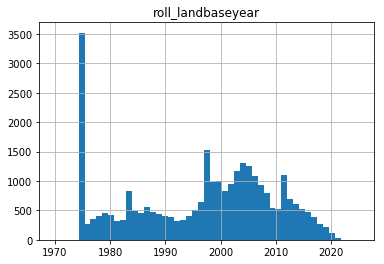

In [1]:
# %%time
import pandas as pd
import psycopg2
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# read data from local psql database into pd dataframe
try:
    #conn = psycopg2.connect(database='parcelDatabase', user=os.getenv(
    #    "USER"), password=os.getenv("PASSWORD"))
    conn = psycopg2.connect(database='parceldatabase', user="newuser", password="password")
    print("successfully connected to database")
except:
    print("I am unable to connect to the database")
df = pd.read_sql_query('select * from "svr_table_2"', con=conn)

# print(df.head())
print(df.iloc[0].situszip5)

# taking out irrelevant columns and cols related to building/development on land. Usecode is relevant col but dropping
# b/c we can't parse it rn
# isTaxableParcel is yes for all, so it's not needed here
# usecodedescchar1/usecodedescchar2 are captured by usecode
drop_cols = ['istaxableparcel', 'usecodedescchar1', 'usecodedescchar2']

cat_cols = ['usecode']

df = df.drop(drop_cols, 1)

# convert columns of df to numeric
numeric_cols = ["roll_landbaseyear", "taxratearea", 
                "center_lat", "cluster", "situszip5",
                "center_lon", "roll_landvalue", "sqftmain", 
                "effectiveyearbuilt", "yearbuilt"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

#  add land value per sqft column
df['landvalue_per_sqft'] = df['roll_landvalue'] / df['sqftmain']

# some basic visuals on distr of the land base year
df.hist(column="roll_landbaseyear", range=[1970, 2025], bins=51)

df_updated_2020 = df[df["roll_landbaseyear"] == 2020]
df_updated_2021 = df[df["roll_landbaseyear"] == 2021]

print("# of parcels updated in 2020: ", len(df_updated_2020))
print("# of parcels updated in 2021: ", len(df_updated_2021))
print("total # of parcels in table: ", len(df))
df.head()


In [ ]:
# !pip install sklearn_pandas
# !pip3 install -U sklearn_pandas

based on this reference: https://www.kaggle.com/gauthampughazh/house-sales-price-prediction-svr/notebook

In [2]:
%%time
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from IPython.display import FileLink


CPU times: user 457 ms, sys: 523 ms, total: 980 ms
Wall time: 1.62 s


In [3]:
# method to turn all characters from usecode to numbers instead of letters
lettersToNumbers = {"A": 10, "B": 11, "C": 12, "D": 13, "E": 14, "F": 15, "G": 16,
                    "H": 17, "I": 18, "J": 19, "K": 20, "L": 21, "M": 22, "N": 23,
                    "O": 24, "P": 25, "Q": 26, "R": 27, "S": 28, "T": 29, "U": 30,
                    "V": 31, "W": 32, "X": 33, "Y": 34, "Z": 35, " ": -1}
def encode(col):
    for x in lettersToNumbers:
        df[col] = df[col].replace(x,lettersToNumbers[x])

In [4]:
# create a new column for each use code character
df['usecode1'] = df['usecode'].astype(str).str[0]
df['usecode2'] = df['usecode'].astype(str).str[1]
df['usecode3'] = df['usecode'].astype(str).str[2]
df['usecode4'] = df['usecode'].astype(str).str[3]

# turn all letters in these new columns into numbers
encode('usecode1')
encode('usecode2')
encode('usecode3')
encode('usecode4')

# turn new cols into numeric values instead of string values
usecode_cols = ['usecode1', 'usecode2', 'usecode3', 'usecode4']
df[usecode_cols] = df[usecode_cols].apply(pd.to_numeric)

# drop use code column since it is now represented by other cols
df = df.drop(['usecode'],1)

df.head()

,ain,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landvalue,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft,usecode1,usecode2,usecode3,usecode4
0,5454027038,4,1994,1994,779,65955.0,1987,27680,90065,34.095796,-118.228163,84.666239,1,1,0,0
1,6052030026,461,1964,1964,1000,8339.0,1975,26631,90003,33.947870,-118.265508,8.339000,1,1,0,0
2,5359005001,1797,1961,1961,612,61899.0,1975,27630,91801,34.078510,-118.118021,101.142157,1,1,0,0
3,4231018015,67,1949,1949,621,31585.0,1975,25691,90066,33.996502,-118.428373,50.861514,1,1,0,0
4,4263011036,67,1987,1987,975,1828489.0,2000,23687,90025,34.049304,-118.460372,1875.373333,2,5,0,0


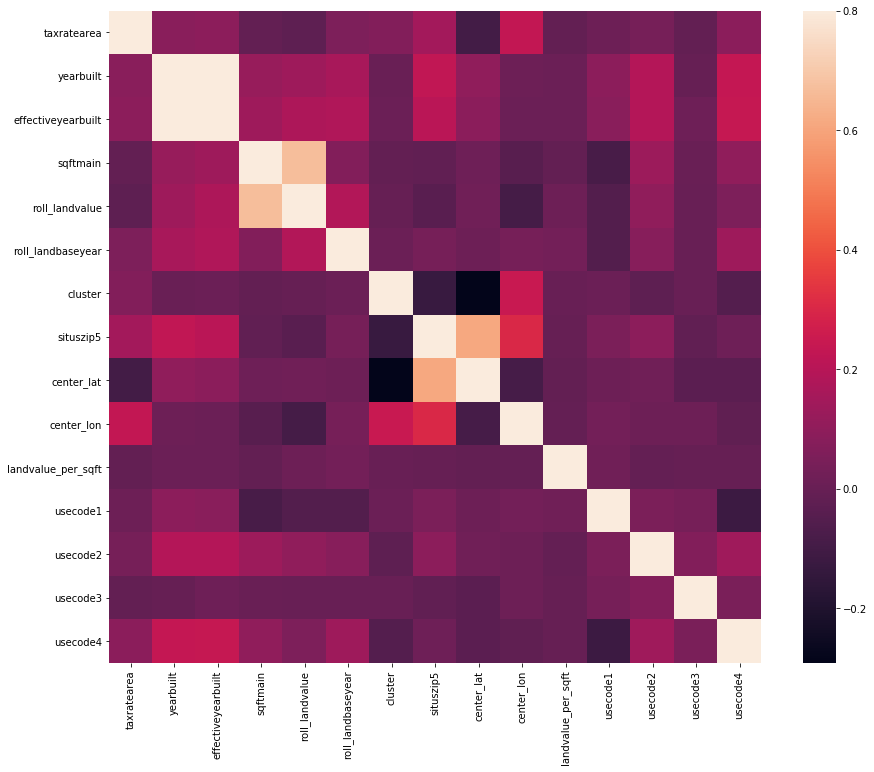

In [5]:

# split data into test and train
train_df, test_df = train_test_split(df, test_size=0.2)

# get correlation matrix
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, vmax=0.8, square=True)
plt.show()


In [6]:
# Extracting the land value from sample data (what we're trying to find)
Y_train = train_df['roll_landvalue'].values
train_df = train_df.drop(['roll_landvalue'], axis=1)


In [7]:
X_train = train_df 
X_test = test_df 
X_train.head()


,ain,taxratearea,yearbuilt,effectiveyearbuilt,sqftmain,roll_landbaseyear,cluster,situszip5,center_lat,center_lon,landvalue_per_sqft,usecode1,usecode2,usecode3,usecode4
17966,3001138003,8739,2005,2005,17515,2004,24615,93551,34.629395,-118.219448,15.230203,1,5,0,0
25846,6022001005,6659,1932,1936,1167,2002,26604,90003,33.974403,-118.272401,45.383890,1,1,0,0
19836,8654016004,4127,1964,1964,1468,2003,27609,91740,34.126727,-117.820724,278.466621,2,6,0,0
25380,8265062029,8267,1983,1983,32578,2003,23671,91748,33.992125,-117.921585,57.402879,1,7,0,0
20201,5157021006,67,1922,1970,1076,2010,25694,90026,34.067155,-118.269644,231.948885,1,9,1,0


In [8]:
models = [AdaBoostRegressor(learning_rate=2),
          SVR(kernel='linear'),
          RandomForestRegressor(n_estimators=200, random_state=1)]
errors = []
for model in models:
    model_name = model.__class__.__name__
    error = np.sqrt(abs(cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error'))).mean()
    errors.append([model_name, error])
    
result_df = pd.DataFrame(errors, columns=['Model name', 'Average error'])

In [ ]:
result_df